In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

%matplotlib inline

/home/michael/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def batch_data(x, y, size):
    perm = np.arange(len(x))
    np.random.shuffle(perm)
    x = x[perm]
    y = y[perm]
    return x[:size],y[:size]

In [3]:
df = pd.read_csv('data/train.csv')
images = df[df.columns[1:]]
given_label = df['label']

images = images.values
images = np.multiply(images, 1.0 / 255.0)
labels = pd.get_dummies(given_label).values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(images,
                                                    labels,
                                                    test_size = .25,random_state=4444)

# Convolutional NN

### Weights, Biases, Convolution, Pooling for the Rectified Linear Units(Neuron)


In [5]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name='weights')

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name='biases')

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name='convolution')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME', name='pool')

In [9]:
sess = tf.InteractiveSession()

In [20]:
with tf.Graph().as_default():
    x = tf.placeholder(tf.float32, [None, 784])
    W = tf.Variable(tf.zeros([784, 10]))
    b = tf.Variable(tf.zeros([10]))
    y_ = tf.placeholder(tf.float32, [None, 10])
    
#Inference
    with tf.name_scope('hidden1'):
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        x_image = tf.reshape(x, [-1,28,28,1])
        hidden1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    with tf.name_scope('hidden2'):
        h_pool1 = max_pool_2x2(hidden1)
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    with tf.name_scope('fully_connected'):
        h_pool2 = max_pool_2x2(h_conv2)
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        fully_connected = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        dropout = tf.nn.dropout(fully_connected, keep_prob)

    with tf.name_scope('softmax'):
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])
        y_conv=tf.nn.softmax(tf.matmul(dropout, W_fc2) + b_fc2)

#Loss
    cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv), name='xentropy')
    
#Training
    tf.scalar_summary(cross_entropy.op.name, cross_entropy)
    global_step=tf.Variable(0,name='global_step',trainable=False)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy,global_step=global_step)
    
#Evaluation
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#Log Creation
    summary_op = tf.merge_all_summaries()
    sess = tf.Session()
    init = tf.initialize_all_variables()
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(init)

        summary_writer = tf.train.SummaryWriter('tensor_flow_logs',graph_def=sess.graph_def)
    #TrainingLoop
        for i in range(20000):
            x_batch, y_batch = batch_data(X_train,y_train,50)
            feed_dict = {x: x_batch, y_: y_batch, keep_prob:1.0}
            sess.run([train_step,cross_entropy,accuracy],feed_dict=feed_dict)
            if i%100 == 0:
                acc = sess.run(accuracy, feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0})
                summary_str = sess.run(summary_op, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, i)
                print("step %d, training accuracy %g"%(i, acc))
            if i%1000 == 0:
                save_path = saver.save(sess,"data/model_newest.ckpt")
                print("Model saved in file: %s" % save_path)

step 0, training accuracy 0.1
Model saved in file: data/model.ckpt
step 100, training accuracy 0.94
step 200, training accuracy 0.86
step 300, training accuracy 0.9
step 400, training accuracy 0.94
step 500, training accuracy 1
step 600, training accuracy 0.94
step 700, training accuracy 0.96
step 800, training accuracy 1
step 900, training accuracy 0.96
step 1000, training accuracy 0.98
Model saved in file: data/model.ckpt
step 1100, training accuracy 0.96
step 1200, training accuracy 0.94
step 1300, training accuracy 0.94
step 1400, training accuracy 0.98
step 1500, training accuracy 0.98
step 1600, training accuracy 1
step 1700, training accuracy 0.98
step 1800, training accuracy 0.96
step 1900, training accuracy 0.96
step 2000, training accuracy 1
Model saved in file: data/model.ckpt
step 2100, training accuracy 1
step 2200, training accuracy 0.96
step 2300, training accuracy 1
step 2400, training accuracy 0.98
step 2500, training accuracy 1
step 2600, training accuracy 0.96
step 2

InvalidArgumentError: ReluGrad input is not finite. : Tensor had NaN values
	 [[Node: gradients/hidden1/Relu_grad/hidden1/Relu/CheckNumerics = CheckNumerics[T=DT_FLOAT, message="ReluGrad input is not finite.", _device="/job:localhost/replica:0/task:0/cpu:0"](hidden1/add)]]
Caused by op u'gradients/hidden1/Relu_grad/hidden1/Relu/CheckNumerics', defined at:
  File "/home/michael/anaconda2/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/michael/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/michael/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 589, in launch_instance
    app.start()
  File "/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/home/michael/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/michael/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/michael/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-1db7ca6c1400>", line 42, in <module>
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy,global_step=global_step)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/optimizer.py", line 186, in minimize
    aggregation_method=aggregation_method)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/optimizer.py", line 232, in compute_gradients
    aggregation_method=aggregation_method)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients.py", line 445, in gradients
    in_grads = _AsList(grad_fn(op_wrapper, *out_grads))
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_grad.py", line 126, in _ReluGrad
    t = _VerifyTensor(op.inputs[0], op.name, "ReluGrad input is not finite.")
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_grad.py", line 119, in _VerifyTensor
    verify_input = array_ops.check_numerics(t, message=msg)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 48, in check_numerics
    name=name)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 664, in apply_op
    op_def=op_def)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1834, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1043, in __init__
    self._traceback = _extract_stack()

...which was originally created as op u'hidden1/Relu', defined at:
  File "/home/michael/anaconda2/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
[elided 17 identical lines from previous traceback]
  File "/home/michael/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-1db7ca6c1400>", line 12, in <module>
    hidden1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 547, in relu
    return _op_def_lib.apply_op("Relu", features=features, name=name)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 664, in apply_op
    op_def=op_def)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1834, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/michael/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1043, in __init__
    self._traceback = _extract_stack()


In [ ]:
sess = tf.InteractiveSession()

In [21]:
with tf.Graph().as_default():
    x = tf.placeholder(tf.float32, [None, 784])
    W = tf.Variable(tf.zeros([784, 10]))
    b = tf.Variable(tf.zeros([10]))
    y_ = tf.placeholder(tf.float32, [None, 10])
    
#Inference
    with tf.name_scope('hidden1'):
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        x_image = tf.reshape(x, [-1,28,28,1])
        hidden1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    with tf.name_scope('hidden2'):
        h_pool1 = max_pool_2x2(hidden1)
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    with tf.name_scope('fully_connected'):
        h_pool2 = max_pool_2x2(h_conv2)
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        fully_connected = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        dropout = tf.nn.dropout(fully_connected, keep_prob)

    with tf.name_scope('softmax'):
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])
        y_conv=tf.nn.softmax(tf.matmul(dropout, W_fc2) + b_fc2)

#Loss
    cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv), name='xentropy')
    
#Training
    tf.scalar_summary(cross_entropy.op.name, cross_entropy)
    global_step=tf.Variable(0,name='global_step',trainable=False)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy,global_step=global_step)
    
#Evaluation
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#Log Creation
    summary_op = tf.merge_all_summaries()
    sess = tf.Session()
    init = tf.initialize_all_variables()
    saver = tf.train.Saver()

#Restore
    saver.restore(sess,"data/model.ckpt")
    ac = sess.run(accuracy, feed_dict={x: X_test, y_: y_test, keep_prob: 1.0})

In [22]:
ac

0.98923808

In [23]:
print("test accuracy {}".format(ac))

test accuracy 0.989238083363


# Visualizing Residuals

In [64]:
y_fit = sess.run(tf.argmax(y_conv,1),feed_dict={x: test, keep_prob:1})

In [65]:
y_fit

array([7])

In [27]:
def undummy(arr):
    num = []
    for i in arr:
        for j in range(len(i)):
            if i[j]==1.0:
                num.append(j)
    return num                 

In [28]:
ys = np.array(undummy(y_test))

In [29]:
def show_img(i):
    boximages = np.array(X_test).reshape(len(X_test),28,28)
    print 'Actual:', list(y_test)[i]
    print 'Predicted:', list(y_fit)[i]
    plt.matshow(boximages[i],cmap=plt.cm.Greys)

In [30]:
residual_index = [i for i, (val,valb) in enumerate(zip(ys,y_fit)) if val!=valb]

In [31]:
residual_index

[50,
 73,
 152,
 234,
 322,
 328,
 355,
 457,
 487,
 601,
 792,
 1182,
 1193,
 1376,
 1403,
 1417,
 1482,
 1490,
 1513,
 1554,
 1719,
 1913,
 1917,
 2204,
 2455,
 2501,
 2584,
 2811,
 2812,
 2908,
 3031,
 3225,
 3433,
 3475,
 3651,
 3737,
 3748,
 4027,
 4202,
 4228,
 4237,
 4332,
 4351,
 4356,
 4368,
 4752,
 4776,
 4857,
 5050,
 5064,
 5107,
 5220,
 5231,
 5237,
 5282,
 5286,
 5347,
 5487,
 5724,
 5893,
 5913,
 6192,
 6200,
 6305,
 6717,
 6773,
 6811,
 6876,
 6884,
 7047,
 7107,
 7326,
 7342,
 7409,
 7568,
 7627,
 7629,
 7632,
 7693,
 7730,
 7885,
 7908,
 7943,
 8267,
 8340,
 8351,
 8509,
 8515,
 8523,
 8535,
 8546,
 8567,
 8692,
 9181,
 9264,
 9540,
 9838,
 9969,
 10058,
 10147,
 10371,
 10487]

Actual: [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
Predicted: 9


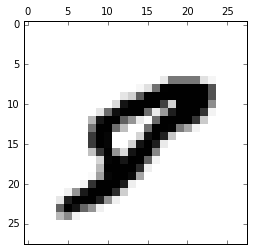

In [32]:
show_img(50)

In [33]:
residual = [val!=valb for i, (val,valb) in enumerate(zip(ys,y_fit))]
residual = np.array(residual)
X_images = np.array(X_test).reshape(len(X_test),28,28)
X_residual = X_images[residual]

In [34]:
def plot_averages(data,actual):
    fig = plt.figure(figsize = (10,6))
    for i in range(10):
        plt.subplot(2,5,i+1).matshow(np.mean(data[np.array(actual==i)], axis=0),cmap=plt.cm.Greys)
        plt.title('Number: {}'.format(i))
        plt.subplot(2,5,i+1).xaxis.set_ticks_position('bottom')

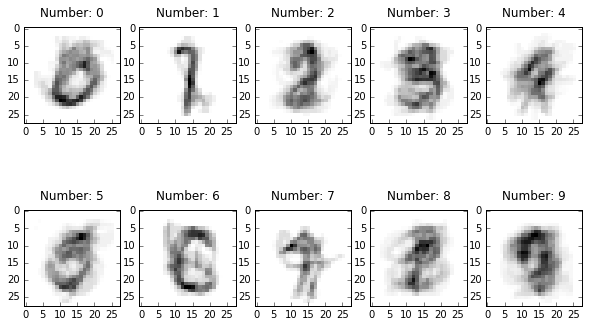

In [35]:
plot_averages(X_residual,ys[residual])

# Confusion

In [36]:
confusion = np.zeros([10,10])
for i,j in zip(ys,y_fit):
    confusion[i][j]+=1

In [37]:
percentage = confusion/np.sum(confusion, axis=1)

In [38]:
for i in range(10):
    percentage[i][i] = 0

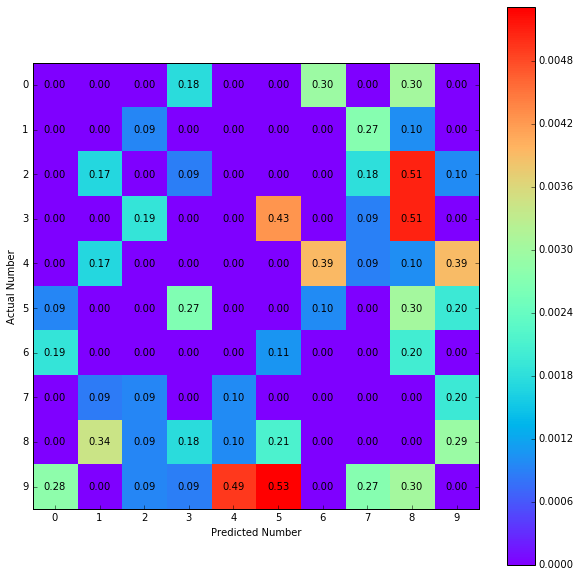

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
# plt.figure()
c = ax.matshow(percentage,cmap=plt.cm.rainbow)
fig.colorbar(c)
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel('Predicted Number')
plt.ylabel('Actual Number')

for (i, j), z in np.ndenumerate(percentage):
    ax.text(j, i, '{:0.2f}'.format(z*100), ha='center', va='center')
    ax.xaxis.set_ticks_position('bottom')

In [40]:
from sklearn.metrics import classification_report

In [41]:
print classification_report(ys,y_fit,digits=5)

             precision    recall  f1-score   support

          0    0.99436   0.99249   0.99342      1065
          1    0.99231   0.99572   0.99401      1167
          2    0.99433   0.98966   0.99199      1064
          3    0.99201   0.98937   0.99069      1129
          4    0.99306   0.98815   0.99060      1013
          5    0.98727   0.98937   0.98832       941
          6    0.99215   0.99508   0.99361      1016
          7    0.99095   0.99545   0.99320      1100
          8    0.97688   0.98680   0.98182       985
          9    0.98813   0.97941   0.98375      1020

avg / total    0.99030   0.99029   0.99029     10500

